### Bimodal noise BNN_LV with PYMC3
Using NUTS in pymc3 to sample from posterior of BNN_LV

Samples saved out: `saved_samples/bimodal_samples_pymc3.npy`


In [3]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys
import wandb
import pymc3 as pm
import theano.tensor as tt
from IPython.core.debugger import set_trace
%matplotlib inline

In [37]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from utils.data_gen import sample_gaussian_mixture, generate_regression_outputs
from utils.BNN_pymc3 import BNN_LV as BNN_LV_pymc3
from utils.custom_callbacks_pymc3 import plot95ci, wb_scatter, build_wb_callback

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Bimodal Noise

### Generate Data

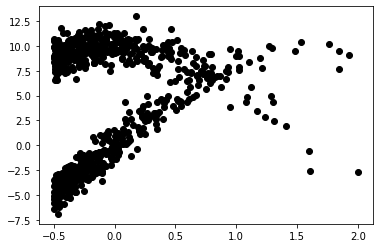

In [22]:
y_bimodal, X_bimodal = generate_regression_outputs(type='bimodal')
plt.scatter(X_bimodal.flatten(), y_bimodal.flatten(), color='black', label='data')

### Setup BNN_LV architecture and perform MLE fit

In [24]:
# Parameters
gamma = 1
sigma = 1

architecture = {'input_n':1, 
             'output_n':1, 
             'hidden_layers':[20,20],
             'biases' : [1,1,1],
             'activations' : ['relu', 'relu', 'linear'],
             'gamma':[gamma],
             'sigma':[sigma]}
bnn_lv = BNN_LV_pymc3(architecture=architecture)
bnn_lv.fit(X_bimodal, y_bimodal, step_size=0.01, max_iteration=5000, check_point=500, regularization_coef=None)

Iteration 0 lower bound 133.35116818362545; gradient mag: 348.11341563739916
Iteration 500 lower bound 29.55343221616535; gradient mag: 0.06501048576799687
Iteration 1000 lower bound 29.538128106008507; gradient mag: 0.11237642738761905
Iteration 1500 lower bound 29.530085763911153; gradient mag: 0.17035136578152002
Iteration 2000 lower bound 29.52542693763203; gradient mag: 0.25552825418661507
Iteration 2500 lower bound 29.507958219806024; gradient mag: 0.26190531282616597
Iteration 3000 lower bound 29.4657009200588; gradient mag: 0.4412718577849898
Iteration 3500 lower bound 29.393562956396877; gradient mag: 1.9253422362392676
Iteration 4000 lower bound 29.30470030026629; gradient mag: 1.267909772952582
Iteration 4500 lower bound 29.201151577668295; gradient mag: 4.117702135230634


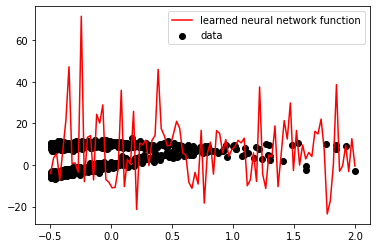

In [25]:
x_test = np.linspace(min(X_bimodal), max(X_bimodal), 100).reshape((1, -1))

#predict on the test x-values
y_test_pred = bnn_lv.forward(x_test.reshape(100,1))

#visualize the function learned by the neural network
plt.scatter(X_bimodal.flatten(), y_bimodal.flatten(), color='black', label='data')
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='red', label='learned neural network function')
plt.legend(loc='best')
plt.show()

### Prepare parameters for pymc3 sampling

In [27]:
# variable parameters
p_mu = 0
p_sigma = 5
l_sigma = 0.25
lv_gamma = 1

# pymc3 NUTS parameters
my_tune = 200
my_draws = 150
my_target_accept = 0.9
my_max_treedepth = 15


nn = bnn_lv
X_test = np.linspace(min(X_bimodal), max(X_bimodal), 100).reshape((1, -1))

# Initialize a W&B run:
wandb.init(
    entity    = 'gpestre',  # Don't change this.
    project   = 'am207',  # Don't change this.
    group     = 'pymc3_bimodal',
    name      = 'bimodal_attempt',
    notes     = 'adjusting NUTS parameters',
    config    = {
        # Manually archive info about network and priors.
        'architecture' : architecture,
        'p_mu' : p_mu,
        'p_sigma' : p_sigma,
        'l_sigma' : l_sigma,
        'lv_gamma' : lv_gamma,
        'tune' : my_tune,
        'draws' : my_draws,
        'max_treedepth': my_max_treedepth,
        'target_accept': my_target_accept,
    },
)

wb_callback = build_wb_callback(nn=bnn_lv, X=X_bimodal, iters_log=50, iters_plot=250)

### Run pymc3

In [ ]:
with pm.Model() as pm_model:
    
    #prior on w (same shape as MLE weights)
    w_prior = pm.Normal('w', mu=p_mu, sigma=p_sigma, shape=bnn_lv.weights.shape) 
    
    # Latent variable prior (same shape as number of datapoints)
    lv_prior = pm.Normal('z', mu=0, sigma=lv_gamma, shape=(X_bimodal.shape[0],1))
    
    # Y with X,LV
    y = pm.Normal('y', mu = bnn_lv.forward(X = X_bimodal, input_noise = lv_prior, weights=w_prior),
                       sigma = l_sigma,
                       observed = y_bimodal)
    
    # NUTS sampling
    trace = pm.sample(tune=my_tune, draws=my_draws, start = {'w': bnn_lv.weights},
                      target_accept = my_target_accept, max_treedepth = my_max_treedepth,
                      callback=wb_callback)

In [ ]:
wb_scatter(nn=nn, X=X_test, trace_w=trace['w'])

wandb.finish()

### Complete sampling and save/load samples obtained

In [33]:
# np.save('saved_samples/bimodal_samples_pymc3.npy',trace['w'])
posterior_samples_pymc3_bimodal = np.load('saved_samples/bimodal_samples_pymc3.npy')

In [36]:
posterior_samples_pymc3_bimodal.shape

(600, 1, 501)